# Application of ConvNet for Dogs vs Cats Image Classification With Image Augmentation 

In [1]:
#Importing required packages
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import sklearn


In [2]:
# The dataset for used for this training is the filtered version of Dogs vs. Cats dataset from Kaggle via googleapis (ultimately, this dataset is provided by Microsoft Research).
# Directly download Dogs vs. Cats from a googlepis URL and unzip it to the Colab filesystem.

URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
file_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=URL, extract=True)


68606236/68606236 [==============================] - 2s 0us/step


In [3]:
file_dir

'/root/.keras/datasets/cats_and_dogs_filterted.zip'

In [4]:
# Assign variables for each path in the directory

base_dir = os.path.join(os.path.dirname(file_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [5]:
print('Train Dataset Directory:', train_dir)
print('Validation Dataset Directory:', validation_dir)

Train Dataset Directory: /root/.keras/datasets/cats_and_dogs_filtered/train
Validation Dataset Directory: /root/.keras/datasets/cats_and_dogs_filtered/validation


In [6]:
train_dogs_dir = os.path.join(train_dir, 'dogs')
train_cats_dir = os.path.join(train_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')

In [7]:
print('Total training cat images:', len(os.listdir(train_cats_dir)))
print('Total training dog images:', len(os.listdir(train_dogs_dir)))

print('Total validation cat images:', len(os.listdir(validation_cats_dir)))
print('Total validation dog images:', len(os.listdir(validation_dogs_dir)))
print("---------------------------------")
print("Total training images:", len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))
print("Total validation images:", len(os.listdir(validation_cats_dir)) + len(os.listdir(train_dogs_dir)))

Total training cat images: 1000
Total training dog images: 1000
Total validation cat images: 500
Total validation dog images: 500
---------------------------------
Total training images: 2000
Total validation images: 1500


In [8]:
# Plot images in the form of a grid with 2 rows and 5 columns where images are placed in each column and rows.
def plotImages(images):
    fig, axes = plt.subplots(2, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [9]:
# Data augmentation generates more training data from training samples, by augmenting the samples through random transformations.
# ImageDataGenerator from Keras can be used to achieve this

# Set augmentation transformations for Train data
train_images_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
  rescale=1./255, #Normalize all pixel values between 0 to 1
  rotation_range=40, #Degree range for random rotations
  #Objects are not in the center of the image. To overcome this problem, the pixels of the images are adjusted horizontally and vertically; this is done by adding a certain constant value to all the pixels. ImageDataGenerator class has the argument height_shift_range for a vertical shift of image and width_shift_range for a horizontal shift of image.
  width_shift_range=0.2, # Shift horizontally by 20%
  height_shift_range=0.2, # Shift vertically by 20%
  shear_range=0.2, # Set share intensity
  zoom_range=0.2, # To Zoom into the images, set zoom_range < 1
  horizontal_flip=True, #Flipping images horizontally
)

# Set Rescale property only on validation data. This data will be used to test the model, Hence should contain exact properties
validation_images_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
  rescale=1./255
)

# Read the images directly from the directory with flow_from_directory() and augment them while the neural network model is learning on the training data.
# The method requires images belonging to different classes are present in different folders but are inside the same parent folder i.e train_dir. 
train_data_augmentation = train_images_augmentation.flow_from_directory(
  batch_size= 100, # Number of images to extract from the directory for every batch
  directory=train_dir,# Parent directory
  shuffle=True, # Allow shuffling
  target_size=(150, 150), # resize images to this size
  class_mode='binary' #Number of classes to predict
)

validation_data_augmentation = validation_images_augmentation.flow_from_directory(
  batch_size= 100, # Number of images to extract from the directory for every batch
  directory=validation_dir,# Parent directory
  shuffle=True, # Allow shuffling
  target_size=(150, 150), # resize images to this size
  class_mode='binary' #Number of classes to predict
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


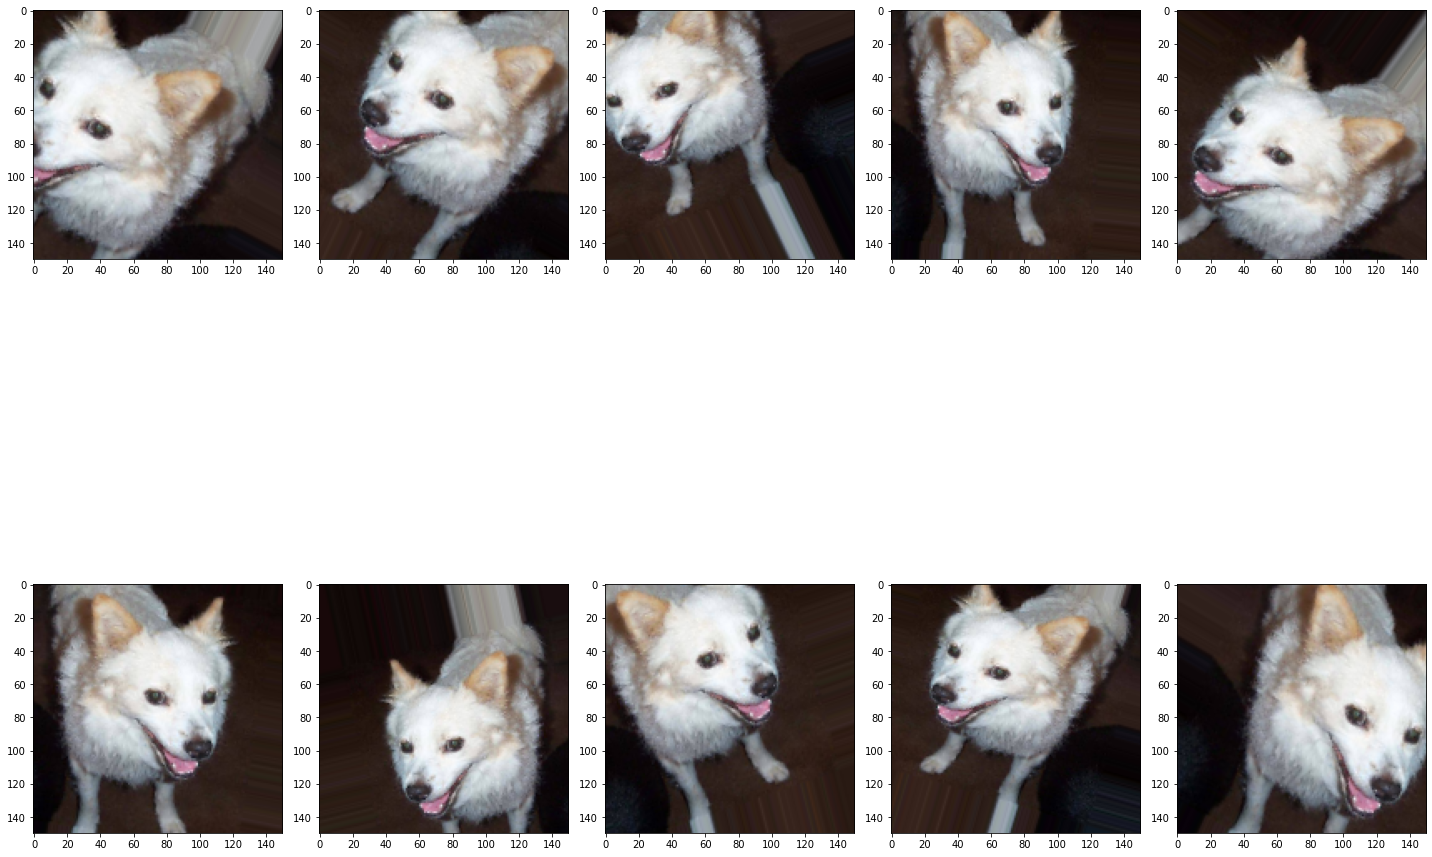

In [10]:
plotImages([train_data_augmentation[0][0][0] for i in range(10)])

In [11]:
# Designing the layers of the convolutional neural network.

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
  tf.keras.layers.MaxPooling2D(2, 2),  
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2), 
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2), 
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2), 
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [13]:
# Compiling the models and assigning the metric, loss function and optimizer parameters.

model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy']
)

In [14]:
print(int(np.ceil(1000 / float(100))))

10


In [15]:
# Fiting the train dataset to the model. fit_generator() is used since batches are coming from a generator (ImageDataGenerator),

model_result = model.fit_generator(
    train_data_augmentation,
    steps_per_epoch= 20,
    epochs= 100,
    validation_data=validation_data_augmentation,
    validation_steps= 10
)

<ipython-input-15-e36e882afabb>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_result = model.fit_generator(


Epoch 1/100
20/20 [==============================] - 26s 844ms/step - loss: 0.7007 - accuracy: 0.5005 - val_loss: 0.6897 - val_accuracy: 0.5000
Epoch 2/100
20/20 [==============================] - 17s 842ms/step - loss: 0.6910 - accuracy: 0.5295 - val_loss: 0.6835 - val_accuracy: 0.6300
Epoch 3/100
20/20 [==============================] - 17s 857ms/step - loss: 0.6835 - accuracy: 0.5525 - val_loss: 0.6682 - val_accuracy: 0.6390
Epoch 4/100
20/20 [==============================] - 18s 908ms/step - loss: 0.6734 - accuracy: 0.5855 - val_loss: 0.6706 - val_accuracy: 0.5760
Epoch 5/100
20/20 [==============================] - 18s 878ms/step - loss: 0.6558 - accuracy: 0.6210 - val_loss: 0.6079 - val_accuracy: 0.6830
Epoch 6/100
20/20 [==============================] - 17s 841ms/step - loss: 0.6225 - accuracy: 0.6405 - val_loss: 0.5830 - val_accuracy: 0.6910
Epoch 7/100
20/20 [==============================] - 18s 892ms/step - loss: 0.6117 - accuracy: 0.6725 - val_loss: 0.5928 - val_accuracy:

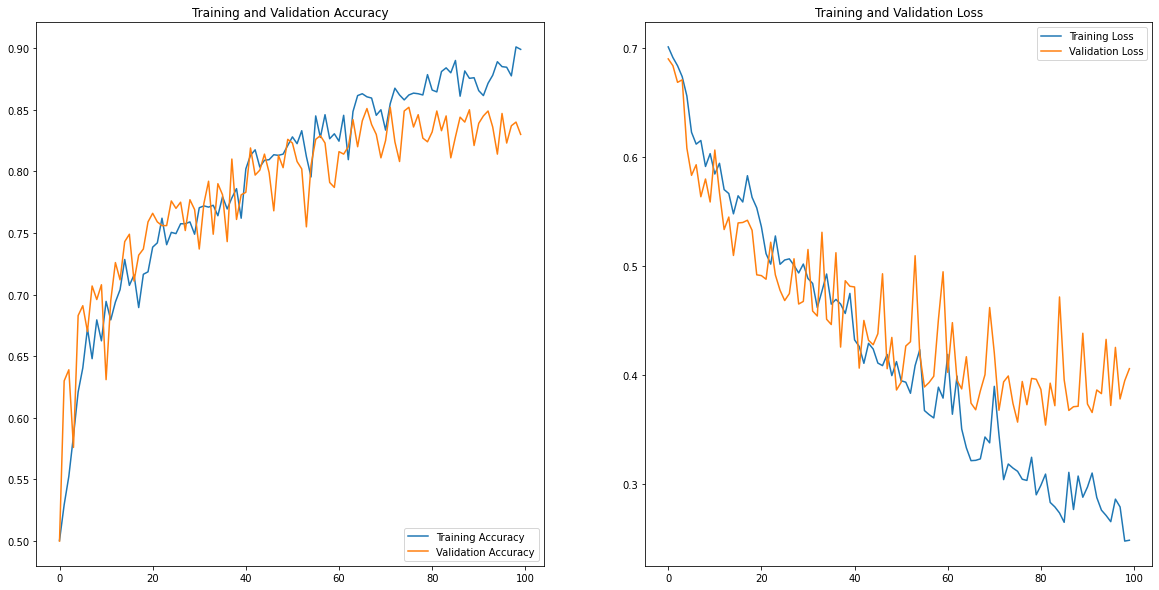

In [21]:
# Display the Accuracy and Loss for both Training and Validation dataset

accuracy = model_result.history['accuracy']
validation_accuracy = model_result.history['val_accuracy']

loss = model_result.history['loss']
validation_loss = model_result.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()